# For Developers

This notebook outlines design choices made in `fast_hdbscan` and is intended for
developers who want to build upon (parts of) `fast_hdbscan` in their projects
(for example, see [the fast_hbcc
repository](https://github.com/vda-lab/fast_hbcc)).

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

sns.set(rc={"figure.figsize":(8,8)})

X, y = make_blobs(centers=3, random_state=42)
X[:, 1] -= X[:, 1].min()

## Main API

`fast_hdbscan` exposes two scikit-learn-style cluster estimators (`HDBSCAN` and
`BranchDetector`) and their respective function versions (`fast_hdbscan()`,
`find_branch_sub_clusters()`) as its main API. This API is demonstrated in the
[basic_usage](basic_usage.ipynb) and
[detecting_branches](detecting_branches.ipynb) pages.

## Building Blocks

The HDBSCAN algorithm consists of two stages, that are each implemented as a
single function: (1) computing the minimum spanning tree and (2) extracting
clusters from a minimum spanning tree. Separating the algorithm into these
stages enables re-use of the cluster extraction functionality on different
minimum spanning trees. For example, to use different local density estimates or
different minimum spanning trees construction algorithms.

1. `fast_hdbscan.hdbscan.compute_minimum_spanning_tree` computes a Euclidean
   mutual reachability distance minimum spanning tree. It takes the data,
   optional sample weights, and a value for `min_samples` as input. Aside from the
   minimum spanning tree edges, the function also returns the `min_samples`-nearest neighbors and the points' core distances:

In [2]:
from fast_hdbscan.hdbscan import compute_minimum_spanning_tree

spanning_tree, neighbors, core_distances = compute_minimum_spanning_tree(
    X, min_samples=5, sample_weights=None
)

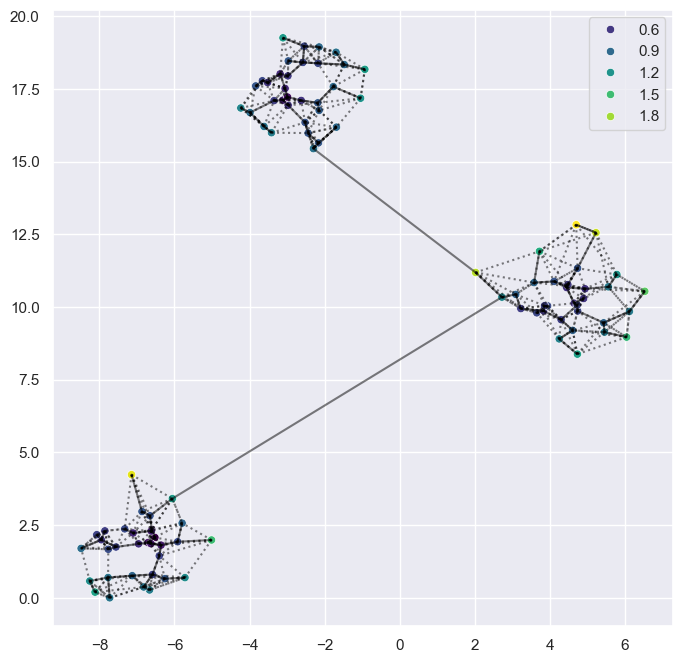

In [3]:
# Core distance colored points
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=core_distances, palette="viridis")

# Dotted neighbor edges
for row, children in enumerate(neighbors):
    for child in children:
        plt.plot(
            [X[row, 0], X[child, 0]],
            [X[row, 1], X[child, 1]],
            c="black",
            linestyle=":",
            alpha=0.5,
        )

# Solid minimum spanning tree edges
for parent, child in spanning_tree[:, :2].astype(int):
    plt.plot(
        [X[parent, 0], X[child, 0]], [X[parent, 1], X[child, 1]], c="black", alpha=0.5
    )

plt.show()

2. `fast_hdbscan.hdbscan.clusters_from_spanning_tree` extracts clusters from a
   minimum spanning tree. It takes the minimum spanning tree as input, together
   with the parameters that control cluster selection. It outputs the resulting
   cluster labels, membership strengths, the single linkage tree, the condensed
   cluster tree, and the sorted minimum spanning tree edges.


In [4]:
from fast_hdbscan.hdbscan import clusters_from_spanning_tree

labels, probability, linkage_tree, condensed_tree, sorted_mst = (
    clusters_from_spanning_tree(
        spanning_tree, min_cluster_size=15, cluster_selection_method="eom"
    )
)

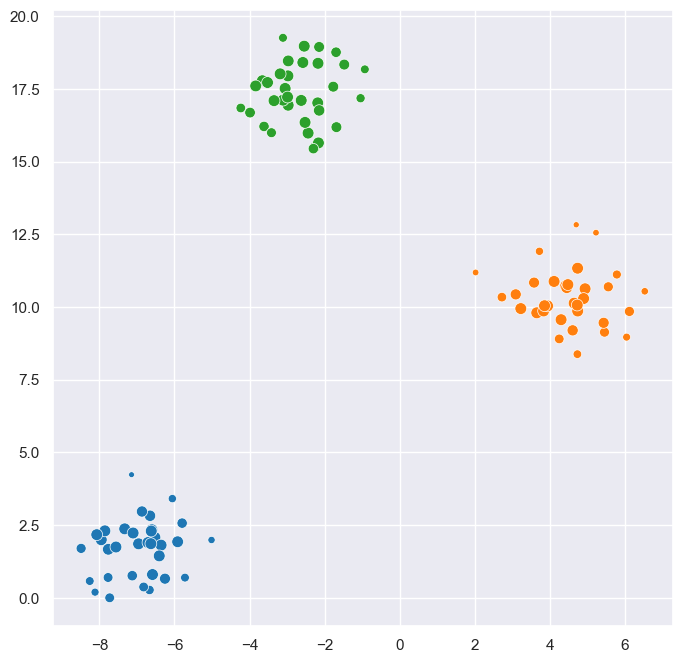

In [5]:
sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=labels, size=probability, palette="tab10", legend=False
)
plt.show()

The branch-detection functionality is also divided into two parts, implemented
in the `core_graph` and `sub_clusters` modules. These modules are implemented
independently of the branch detection functionality. Where the branch detector
uses an eccentricity lens (i.e., a value for each data point), these modules can
be used with any (preferably fairly smooth) lens.

Broadly speaking, the `core_graph` module deals with finding clusters in a
lens dimension while restricting connectivity to the minimum spanning tree and
nearest neighbor edges. The `sub_clusters` module deals with finding such
lensed-clusters within each detected HDBSCAN cluster.


3. `fast_hdbscan.core_graph.core_graph_clusters` extracts lensed-clusters
   restricted to core graph connectivity. First, it creates a core graph with
   edges weighted by the maximum lens value of the points they connect. Second,
   it extract a minimum spanning tree using the lens weights. Finally, it calls
   `clusters_from_spanning_tree` to extract clusters from that minimum spanning
   tree. The output contains everything from `clusters_from_spanning_tree` and
   the constructed core graph in sparse CSR format. Should the function fail to
   create a minimum spanning tree because the core graph contains multiple
   connected components, then the component labels and empty linkage and core
   trees are returned.

In [6]:
from fast_hdbscan.core_graph import core_graph_clusters

# use 1 / y as lens for demonstration
lens = 1 / (X[:, 1] + 1)

labels, probability, linkage_tree, condensed_tree, sorted_mst, graph = (
    core_graph_clusters(
        lens,
        neighbors,
        core_distances,
        spanning_tree,
        min_cluster_size=10,
        cluster_selection_method="eom",
    )
)

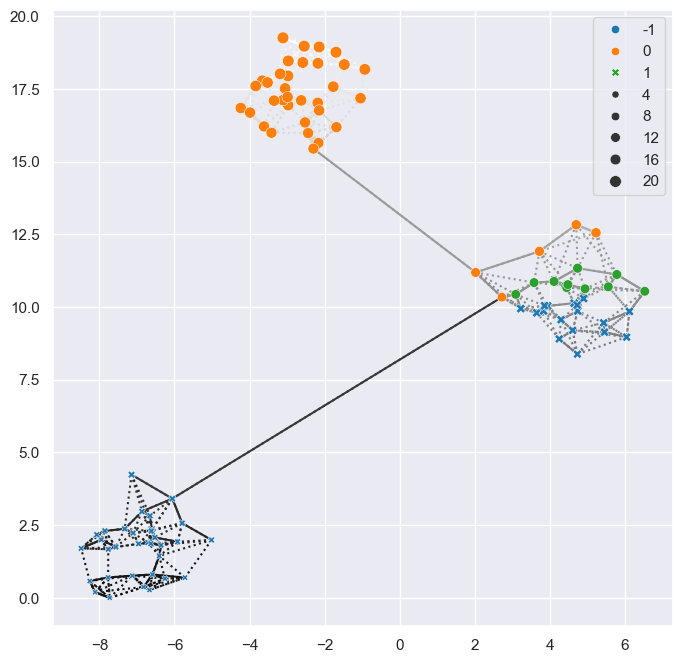

In [7]:
# label-colored, lens-sized points
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=labels,
    style=labels < 0,
    size=1 / lens,
    palette="tab10",
    zorder=100,
)

# dotted lens-colored core_graph edges
for parent, (start, end) in enumerate(zip(graph.indptr, graph.indptr[1:])):
    for child, weight in zip(graph.indices[start:end], graph.weights[start:end]):
        plt.plot(*X[[parent, child]].T, c=f"{(1 / weight) / 20}", linestyle=":")

# solid lens-colored mst edges
for parent, child, weight in sorted_mst:
    parent = int(parent)
    child = int(child)
    plt.plot(*X[[parent, child]].T, c=f"{(1 / weight) / 20}")

plt.show()

4. `fast_hdbscan.sub_clusters.SubClusterDetector` is the general base class for
   `BranchDetector`. It takes either an array with lens values at construction,
   or a callback to compute lens values within a cluster at `.fit(clusterer)`
   and computes lensed clusters within each HDBSCAN detected cluster. The class
   also exposes properties for the minimum spanning trees, single linkage trees,
   condensed cluster trees, and approximation graph.

There are two use cases for the `SubClusterDetector`. Either directly with a pre-computed lens:

In [8]:
from fast_hdbscan import HDBSCAN
from fast_hdbscan.sub_clusters import SubClusterDetector

clusterer = HDBSCAN(min_cluster_size=5).fit(X)
detector = SubClusterDetector(lens_values=lens, min_cluster_size=2).fit(clusterer)

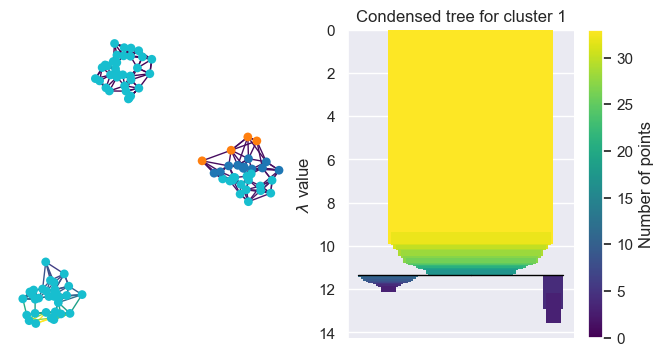

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
detector.approximation_graph_.plot(
    positions=X, node_size=40, node_color="sub_cluster_label", edge_color="lens_value"
)
plt.subplot(1, 2, 2)
detector.condensed_trees_[1].plot()
plt.title("Condensed tree for cluster 1")
plt.show()

Or as a base class with a lens callback. This approach can deal with parameters
on the lens function and provide aliases that make sense for the lens function.

In [10]:
from typing import Literal


def make_y_callback(offset):
    """Takes the detector-specific parameters and returns a callback function."""

    def y_callback(
        data, cluster_probability, neighbors, core_distances, min_spanning_tree, points
    ):
        """
        Parameters
        ----------
        data : np.ndarray
            Full clean data array.
        cluster_probability : np.ndarray
            Full clean array of cluster probabilities.
        neighbors : np.ndarray
            Within cluster neighbor array, with ids relabelled to 0, ..., num_points_in_cluster.
        core_distances : np.ndarray
            Within cluster core distance array.
        points : np.ndarray
            List of clean data point ids for the current cluster.
        """
        return 1 / (data[points, 1] + offset)

    return y_callback


class YDetector(SubClusterDetector):
    def __init__(
        self,
        y_offset: float = 1,  # detector-specific parameter
        min_cluster_size: int | None = None,
        max_cluster_size: int | None = None,
        allow_single_cluster: bool | None = None,
        cluster_selection_method: Literal["eom", "leaf"] | None = None,
        cluster_selection_epsilon: float = 0.0,
        cluster_selection_persistence: float = 0.0,
        propagate_labels: bool = False,
    ):
        super().__init__(
            min_cluster_size=min_cluster_size,
            max_cluster_size=max_cluster_size,
            allow_single_cluster=allow_single_cluster,
            cluster_selection_method=cluster_selection_method,
            cluster_selection_epsilon=cluster_selection_epsilon,
            cluster_selection_persistence=cluster_selection_persistence,
            propagate_labels=propagate_labels,
        )
        self.y_offset = y_offset

    def fit(self, clusterer, labels=None, probabilities=None, sample_weight=None):
        super().fit(
            clusterer,
            labels,
            probabilities,
            sample_weight,
            make_y_callback(self.y_offset),
        )
        self.y_values_ = self.lens_values_  # add y_values_ alias for lens_values_
        return self

    # Override to specify lens and sub_cluster names.
    @property
    def approximation_graph_(self):
        """See :class:`~hdbscan.plots.ApproximationGraph` for documentation."""
        return super()._make_approximation_graph(
            lens_name="y_value", sub_cluster_name="y_cluster"
        )

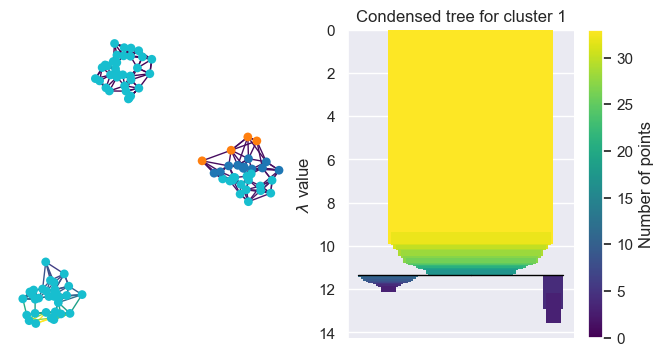

In [12]:
detector = YDetector(min_cluster_size=2).fit(clusterer)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
detector.approximation_graph_.plot(
    positions=X, node_size=40, node_color="y_cluster_label", edge_color="y_value"
)
plt.subplot(1, 2, 2)
detector.condensed_trees_[1].plot()
plt.title("Condensed tree for cluster 1")
plt.show()